In [1]:
import EITfunc.EITlook as eit

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
import matplotlib.cm as cmx
import matplotlib.colorbar as cb
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec

import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')

import os
import copy
import emcee
import corner

from astropy import units as u
from astropy.constants import G
from astropy.io import ascii, fits
from astropy.table import Table
from astropy.timeseries import LombScargle
import astropy.time

import scipy.optimize as sciop
from scipy.stats import mode, binned_statistic
from scipy.signal import medfilt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
def least_squares_line(X,Y,Yerr):
    """
    Solve the normal equation B = (X.T*C.inv*X).inv*X.T*C.inv*Y
    Inputs:
    X = matrix of x values
    bOOT = integer best BIC polynomial OOT order
    Y = vector of y values
    Yerr = vector of yerr values
    Outputs:
    B = vector of model parameters that minimizes chi^2
    Bunc = analytic uncertainties on those parameters (see e.g. )
    """
    # least squares params
    Xmat = np.vander(X, 2)
    
    XTX = np.dot(Xmat.T, Xmat/Yerr[:, None]**2)
    
    B = np.linalg.solve(XTX, np.dot(Xmat.T, Y/Yerr**2))


    #uncertainties on least squares params
    N = len(Y)

    prefac = 1./(np.sum(1./Yerr**2)*np.sum(X**2/Yerr**2) - (np.sum(X/Yerr**2)**2))
    intercept_unc = np.sum( ((prefac/Yerr**2)*(np.sum(X**2/Yerr**2) - X*np.sum(X/Yerr**2)))**2 * Yerr**2)
    slope_unc =     np.sum( ((prefac/Yerr**2)*(-np.sum(X/Yerr**2)   + X*np.sum(1/Yerr**2)))**2 * Yerr**2)

    Bvar = np.array((slope_unc, intercept_unc))
    
    return B, Bvar

In [2]:
def fitparams_to_lineparams(fitparams):
    theta = fitparams[:,0]
    bcostheta = fitparams[:,1]
    scatter = fitparams[:,2]
    m = np.tan(theta)
    b = bcostheta/np.cos(theta)
    return np.vstack((m.T, b.T, scatter.T)).T

def lineparams_to_fitparams(lineparams):
    m = lineparams[:,0]
    b = lineparams[:,1]
    scatter = lineparams[:,2]
    theta = np.arctan2(m,1)
    bcostheta = b * np.cos(theta)
    return np.vstack((theta.T, bcostheta.T, scatter.T)).T

def log_prior(params, theta_bounds, bcostheta_bounds, scatter_bounds):
    """
    Inputs:
    fit parameters:
        theta = arctan(slope)
        b*cos(theta) = perpendicular distance from line to origin
    Returns:
    Log prior for these parameters
    """
    theta = params[0]
    bcostheta = params[1]
    scatter = params[2]
    # theta prior is uniform from 0 to pi
    if theta < theta_bounds[0] or theta >= theta_bounds[1]:
        return -np.inf
    # b*cos(theta) prior is uniform 
    # recall that b*cos(theta) is the perpendicular distance of the line from the origin
    if bcostheta < bcostheta_bounds[0] or bcostheta > bcostheta_bounds[1]:
        return -np.inf

    # scatter prior is uniform
    if scatter < scatter_bounds[0] or scatter > scatter_bounds[1]:
        return -np.inf
    
    return -np.log(theta_bounds[1]-theta_bounds[0]) - np.log(bcostheta_bounds[1]-bcostheta_bounds[0]) - np.log(scatter_bounds[1]-scatter_bounds[0]) 


def log_likelihood(params, x, y, xerr, yerr, xycov=None):
    """
    following Hogg et al. 2010 chapter 7
    Assuming no covariance between data points (bad assumption)
    
    Inputs:
    theta, bcostheta = params at current MCMC step
    x, y, xerr, yerr = arrays of data
                
    Returns:
    Log likelihood calculated for these parameters.
    """

    theta = params[0]
    bcostheta = params[1]
    scatter = params[2]

    if scatter < 0:
        return -np.inf

    # orthogonal displacement of data points from the line parametrized by theta, bcostheta
    delta_arr = -np.sin(theta)*x + np.cos(theta)*y - bcostheta

    # projected covariance matrix 
    #(again assuming no off-diagonal terms)
    if xycov is None:
        xycov = np.zeros_like(x)
    sigma_sq = (np.sin(theta)**2 * xerr**2) - (2*np.sin(theta)*np.cos(theta)*xycov) + (np.cos(theta)**2 * yerr**2)
    '''
    if np.any(np.isnan(sigma_sq)) | np.any(np.isnan(scatter)) | np.any(np.isnan(np.log(sigma_sq+scatter))):
        print("term 1")
        print(-np.sum(0.5*np.log(sigma_sq+scatter)))
        print(np.log(sigma_sq+scatter))
        print(sigma_sq+scatter)
    
        print("term 2")
        print(-np.sum( delta_arr**2/(2*(sigma_sq+scatter)) ))
        print("")
    '''
    ll = -np.sum(0.5*np.log(sigma_sq+scatter)) - np.sum( delta_arr**2/(2*(sigma_sq+scatter)) )
    
    return ll

def log_posterior(params, x, y, xerr, yerr, theta_bounds, bcostheta_bounds, scatter_bounds, samplefile=None, xycov=None):
    theta = params[0]
    bcostheta = params[1]
    
    if samplefile is not None:
        lineparams = fitparams_to_lineparams(params)
        samplef = open(samplefile, "w")
        samplef.write("{0} {1}\n".format(m, b))
        samplef.close()

    prior = log_prior(params, theta_bounds, bcostheta_bounds, scatter_bounds)
    if np.isfinite(prior) is False:
        return -np.inf
    
    likelihood = log_likelihood(params, x, y, xerr, yerr, xycov)
    if np.isfinite(likelihood) is False:
        return -np.inf

    return prior + likelihood


def initialize_walkers(nwalkers, init_theta=np.pi/2, init_bcostheta=0., init_scatter=5.):
    """
    Generates nwalkers random initial positions in ndim space.

    Inputs:
    nwalkers = number of initial positions to generate
    ndim = number of dimensions of parameter space
    init_m = initial guess at slope
    init_b = initial guess at intercept

    Returns:
    pos = array of initial walker positions of shape (nwalkers, ndim=2)
    """
    '''
    lower_prior_bounds = np.array((0, -1*bperp_prior))
    upper_prior_bounds = np.array((np.pi, bperp_prior))
    
    #randomly sampled from 10D box
    pos = np.random.uniform(low=0.01, high=0.99, size=(nwalkers, 2))
    pos = (pos*(upper_prior_bounds - lower_prior_bounds)) + lower_prior_bounds
    '''
    pos = np.zeros((nwalkers, 3))
    pos[:,0] = init_theta + 1.e-2*np.random.randn(nwalkers)
    pos[:,1] = init_bcostheta + 1.e-2*np.random.randn(nwalkers)
    pos[:,2] = init_scatter + 1.e-2*np.random.randn(nwalkers) 

    return pos

def fitMCMCline(x, y, xerr, yerr, theta_bounds=(0,np.pi), bcostheta_bounds=(-10,10), scatter_bounds=(1.e-6, 100), nwalkers=10, nsteps=5000, discard=500, plot=False, prune_unconverged_walkers=False):
    init_guess = initialize_walkers(nwalkers=nwalkers)
    sampler = emcee.EnsembleSampler(nwalkers=nwalkers, ndim=3, log_prob_fn=log_posterior, args=[x, y, xerr, yerr, theta_bounds, bcostheta_bounds, scatter_bounds])

    sampler.run_mcmc(init_guess, nsteps)
    samples = sampler.get_chain()

    labels = ['theta', 'bcostheta', 'scatter']
    linelabels=['m', 'b','scatter']
    
    if plot is True:
        fig, axes = plt.subplots(5,1,figsize=(16,6))
        for i in range(3):
            ax = axes[i]
            ax.plot(samples[:,:,i], 'k',alpha=0.3)
            ax.set_xlim(0,len(samples))
            ax.set_ylabel(labels[i])

        axes[3].plot(np.tan(samples[:,:,0]),'k',alpha=0.3)
        axes[3].set_xlim(0,len(samples))
        axes[3].set_ylabel('m')

        axes[4].plot(samples[:,:,1]/np.cos(samples[:,:,0]),'k',alpha=0.3)
        axes[4].set_xlim(0,len(samples))
        axes[4].set_ylabel('b')

        plt.show()

    if prune_unconverged_walkers is True:
        samples = sampler.get_chain(discard=discard)
        acc_frac = sampler.acceptance_fraction
        print(np.shape(samples))
        print(np.shape(acc_frac))
        n_unconverged_walkers = 0
        for i in range(nwalkers):
            if acc_frac[i] < 0.5*np.median(acc_frac):
                samples[:,i,:] = np.nan
                n_unconverged_walkers += 1

        print("{0} walkers did not converge".format(n_unconverged_walkers))
        
        samples = samples[~np.isnan(samples)]
        flat_samples = samples.reshape((nwalkers-n_unconverged_walkers)*(nsteps-discard), 3)
        print(np.shape(flat_samples))
    else:
        flat_samples = sampler.get_chain(discard=discard, flat=True)
    
    flat_lineparams = fitparams_to_lineparams(flat_samples)
    flat_lineparams_stats = np.percentile(flat_lineparams, q=[16,50,84], axis=0)

    if plot is True:
        fig = corner.corner(flat_samples,labels=labels, quantiles=[0.16,0.5,0.84],show_titles='True')
        fig = corner.corner(flat_lineparams,labels=linelabels, quantiles=[0.16,0.5,0.84],show_titles='True')
   
    print("acceptance fraction is: " + str(np.mean(sampler.acceptance_fraction)))
    return flat_lineparams, flat_lineparams_stats



/opt/anaconda3/lib/python3.12/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


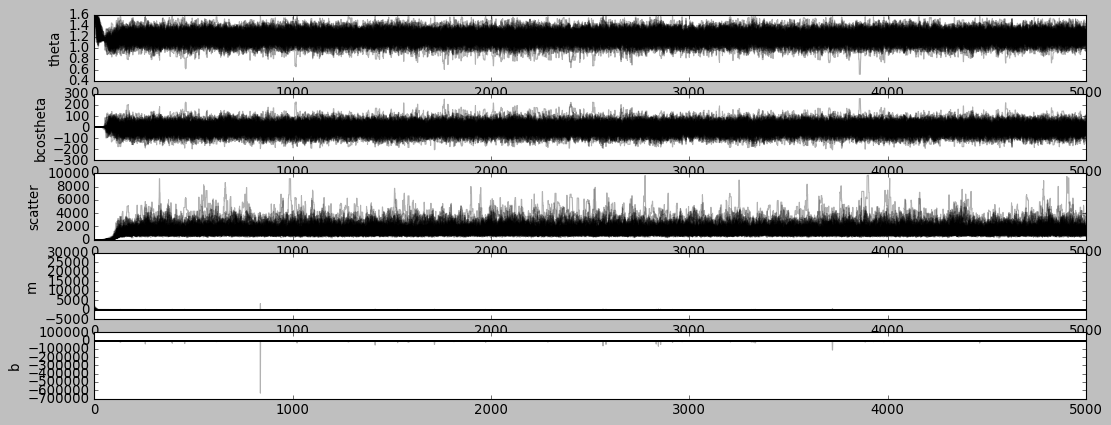

(4000, 100, 3)
(100,)
0 walkers did not converge
(400000, 3)


acceptance fraction is: 0.62943
m is 2.4542766651789045+0.9050751312035712-0.5496448922679702
b is -32.11348042306724+100.62617416632884-164.99822562029104
(400000, 3)


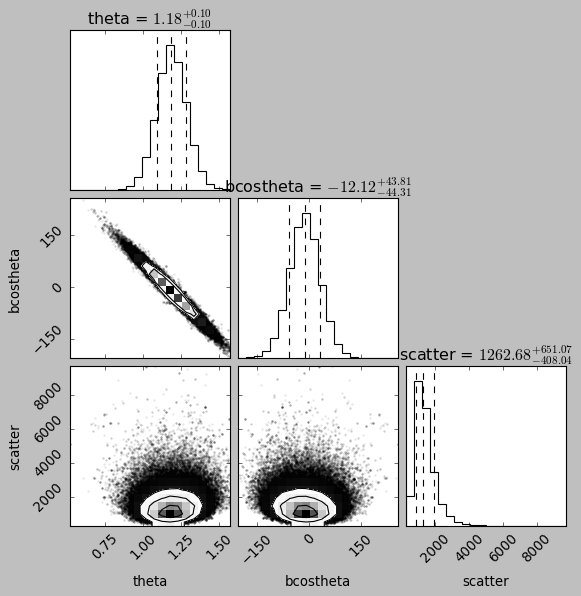

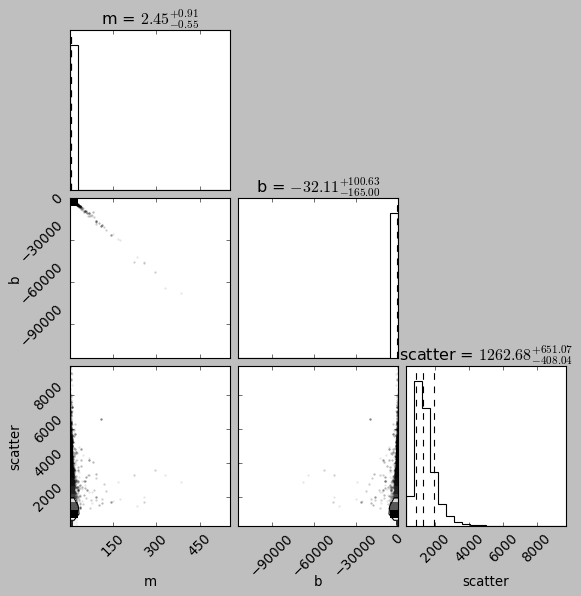

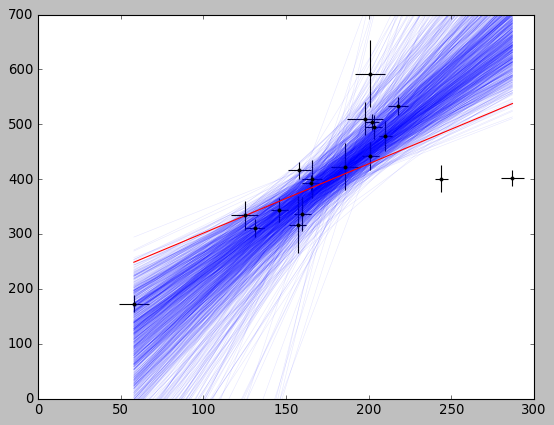

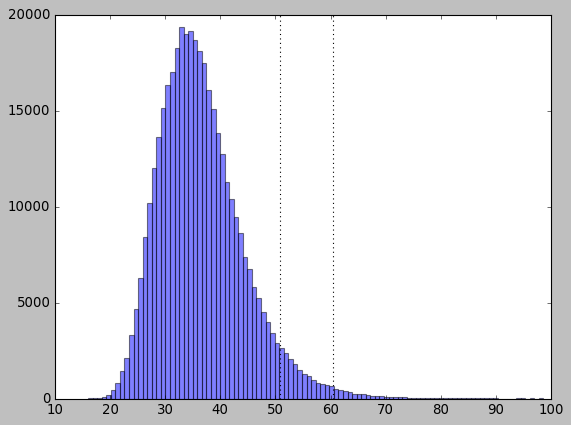

In [5]:
#full hogg+2010 data set
#x = np.array((201,244,47,287,203,58,210,202,198,158,165,201,157,131,166,160,186,125,218,146))
#y = np.array((592,401,583,402,495,173,479,504,510,416,393,442,317,311,400,337,423,334,533,344))
#yerr=np.array((61,25,38,15,21,15,27,14,30,16,14,25,52,16,34,31,42,26,16,22))
#xerr=np.array((9,4,11,7,5,9,4,4,11,7,5,5,5,6,6,5,9,8,6,5))
#exclude point 3
x = np.array((201,244,287,203,58,210,202,198,158,165,201,157,131,166,160,186,125,218,146))
y = np.array((592,401,402,495,173,479,504,510,416,393,442,317,311,400,337,423,334,533,344))
yerr=np.array((61,25,15,21,15,27,14,30,16,14,25,52,16,34,31,42,26,16,22))
xerr=np.array((9,4,7,5,9,4,4,11,7,5,5,5,6,6,5,9,8,6,5))

xsort = np.argsort(x)
x = x[xsort]
y = y[xsort]
xerr = xerr[xsort]
yerr = yerr[xsort]

B, Bvar = least_squares_line(X=x, Y=y, Yerr=yerr)
                             
flat_lineparams, flat_lineparams_stats = fitMCMCline(x, y, xerr, yerr, theta_bounds=(0,np.pi/2),bcostheta_bounds=(-500,500), scatter_bounds=(0,10000), nwalkers=100, nsteps=5000, discard=1000, plot=True,prune_unconverged_walkers=True)
median = flat_lineparams_stats[1]
upper = flat_lineparams_stats[2] - flat_lineparams_stats[1]
lower = flat_lineparams_stats[1] - flat_lineparams_stats[0]

print("m is {0}+{1}-{2}".format(median[0],upper[0],lower[0]))
print("b is {0}+{1}-{2}".format(median[1],upper[1],lower[1]))

print(np.shape(flat_lineparams))
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.errorbar(x,y,xerr=xerr, yerr=yerr, marker='.',color='k',ls='None',elinewidth=1,capsize=0)
rand_idxs = np.random.choice(len(flat_lineparams), 1000)
for i in rand_idxs:
    m = flat_lineparams[i][0]
    b = flat_lineparams[i][1]
    ax.plot(x, m*x + b, 'b-', lw=0.5, alpha=0.1)
ax.plot(x,B[0]*x + B[1],'r-')
ax.set_xlim(0,300)
ax.set_ylim(0,700)
plt.show()

fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.hist(np.sqrt(flat_lineparams[:,2]),bins=100,color='b',alpha=0.5)
ax.axvline(np.percentile(np.sqrt(flat_lineparams[:,2]),95),color='k',ls=':')
ax.axvline(np.percentile(np.sqrt(flat_lineparams[:,2]),99),color='k',ls=':')
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


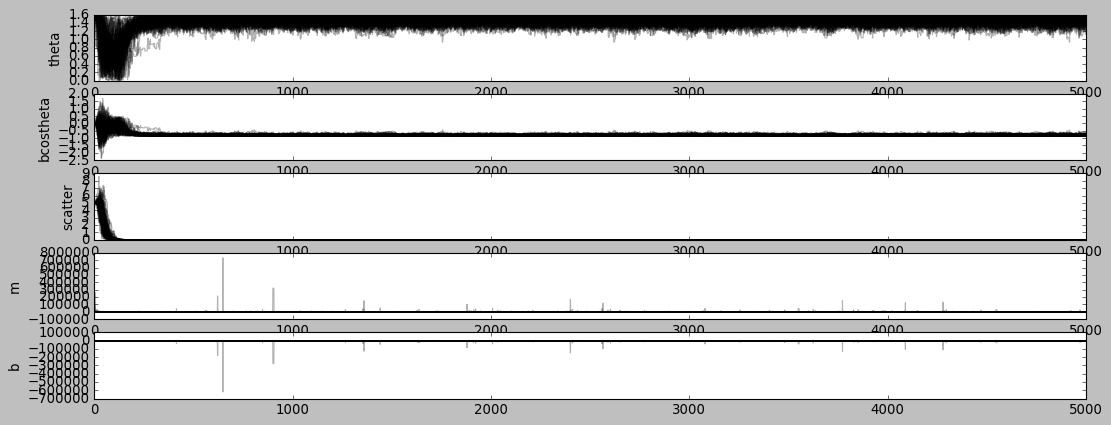

acceptance fraction is: 0.598596
m is 9.221918492688198+17.092634788832612-4.319695062924883
b is -7.471641097169457+3.697053509032772-14.631131207803179
(450000, 3)


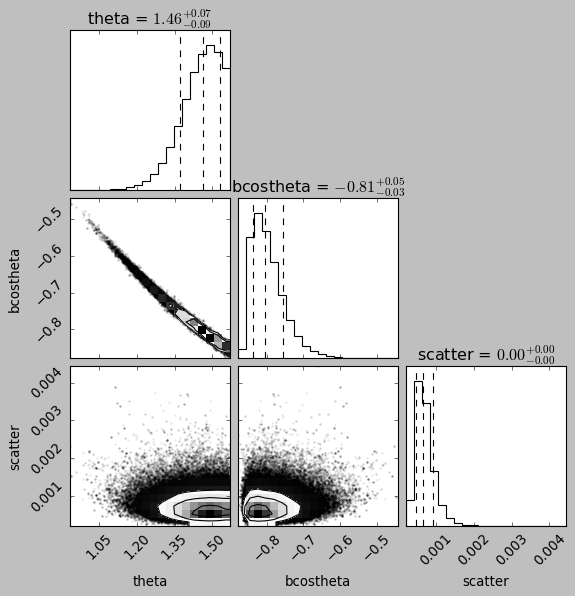

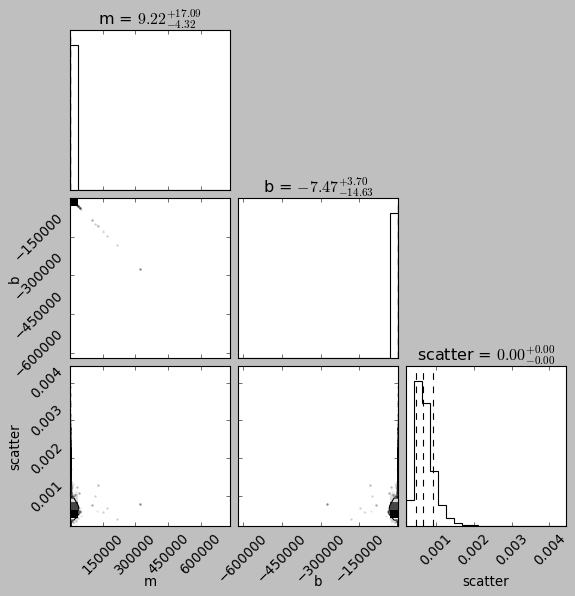

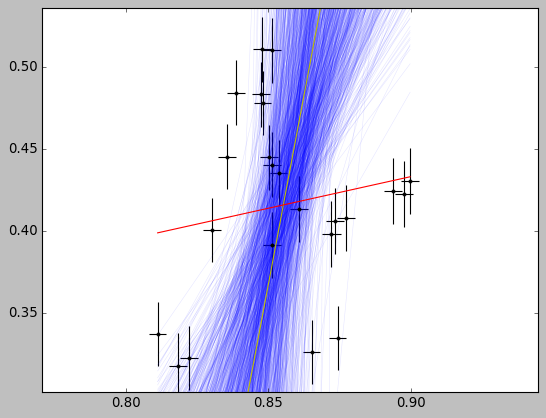

In [6]:

x=np.array((0.86518763, 0.8743743, 0.81822045, 0.82218872, 0.81113462, 0.83027826,0.85361794, 0.85127408, 0.84797507 ,0.84789921, 0.8513024,  0.84743741,0.8385715,  0.83562755, 0.85031074, 0.86085689, 0.87743239, 0.85130059,0.87219546, 0.87337987, 0.89755237, 0.89377721, 0.8998122))
xerr=np.array((0.00308979, 0.00309054, 0.00309107, 0.00309344, 0.0030939,  0.00309458,0.00309453, 0.00310294, 0.00310314, 0.00310372, 0.00310221, 0.00311039,0.00312605, 0.00312619, 0.00313617, 0.00318387, 0.00318387, 0.00318438,0.0031847,  0.0031846 , 0.00318502, 0.0031853,  0.00318601))
y=np.array((0.32588646, 0.33466758, 0.31762944, 0.32219925, 0.33673174, 0.40056889,0.43541787, 0.44035754, 0.47793995, 0.5106892,  0.51013362, 0.48327647,0.48416061, 0.44504003, 0.44477885, 0.4134431,  0.40795002, 0.39134517,0.39798322, 0.40580107, 0.42227752, 0.42434511, 0.4300923))
yerr=np.array((0.01958733, 0.01959682, 0.01960372, 0.0196076,  0.0196101,  0.01961367,0.01965205, 0.01969104, 0.01969406, 0.01969715, 0.01969935, 0.01972959,0.01983113, 0.01977631, 0.01988631, 0.02015853, 0.02016081, 0.02015399,0.02015579, 0.02016649, 0.02016726, 0.02016861, 0.02016564))
xsort = np.argsort(x)
x = x[xsort]
y = y[xsort]
xerr = xerr[xsort]
yerr = yerr[xsort]

B, Bvar = least_squares_line(X=x, Y=y, Yerr=yerr)
flat_lineparams, flat_lineparams_stats = fitMCMCline(x, y, xerr, yerr, theta_bounds=(0,np.pi/2),bcostheta_bounds=(-500,500), scatter_bounds=(0,10000),nwalkers=100, nsteps=5000, discard=500, plot=True)
median = flat_lineparams_stats[1]
upper = flat_lineparams_stats[2] - flat_lineparams_stats[1]
lower = flat_lineparams_stats[1] - flat_lineparams_stats[0]

print("m is {0}+{1}-{2}".format(median[0],upper[0],lower[0]))
print("b is {0}+{1}-{2}".format(median[1],upper[1],lower[1]))

print(np.shape(flat_lineparams))
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.errorbar(x,y,xerr=xerr, yerr=yerr, marker='.',color='k',ls='None',elinewidth=1,capsize=0)
rand_idxs = np.random.choice(len(flat_lineparams), 1000)
for i in rand_idxs:
    m = flat_lineparams[i][0]
    b = flat_lineparams[i][1]
    ax.plot(x, m*x + b, 'b-', lw=0.5, alpha=0.1)
ax.plot(x, flat_lineparams_stats[1][0]*x+flat_lineparams_stats[1][1],'y-')
ax.plot(x,B[0]*x + B[1],'r-')
ax.set_xlim(0.95*np.min(x),1.05*np.max(x))
ax.set_ylim(0.95*np.min(y),1.05*np.max(y))
plt.show()


In [7]:
# functions for fitting linear relationship between two EIT bands at a given bakeout segment
def medianBinEIT(tDaily, tEIT, fEIT, uEIT):
    '''
    median-bin the flux from one EIT band into daily values
    '''
    binned_f, bin_edges, binnumber = binned_statistic(x=tEIT, values=fEIT, statistic='median', bins=tDaily)
    binned_u, bin_edges, binnumber = binned_statistic(x=tEIT, values=uEIT, statistic='mean', bins=tDaily)
    binned_u = np.sqrt((np.pi/2)*binned_u)
    return binned_f, binned_u


def fit2EITBakeoutSegment(t1, f1, u1, t2, f2, u2, t_start, t_end, theta_bounds=(0,np.pi), bcostheta_bounds=(-10,10), scatter_bounds=(0,10),nwalkers=10, nsteps=5000, discard=500, plotMCMC=False,plotFit=True, prune_unconverged_walkers=True):
    """
    fit a linear relationship between two EIT band fluxes over one bakeout segment
    
    t_start = start of bakeout segment [JD]
    t_end = end of bakeout segment[JD]
    """
    
    t1daily = np.arange(np.floor(t1[0]),np.ceil(t1[-1])+1,1)
    binned_f1, binned_u1 = medianBinEIT(tDaily=t1daily,tEIT=t1,fEIT=f1,uEIT=u1)

    t2daily = np.arange(np.floor(t2[0]),np.ceil(t2[-1])+1,1)
    binned_f2, binned_u2 = medianBinEIT(tDaily=t2daily,tEIT=t2,fEIT=f2,uEIT=u2)

    binned_t1 = 0.5*(t1daily[0:-1] + t1daily[1:])
    binned_t2 = 0.5*(t2daily[0:-1] + t2daily[1:])
    
    f1med = np.median(f1[~np.isnan(f1)])
    f2med = np.median(f2[~np.isnan(f2)])
    
    norm_f1 = binned_f1/f1med
    norm_u1 = binned_u1/f1med
    norm_f2 = binned_f2/f2med
    norm_u2 = binned_u2/f2med

    nonans1 = ~np.isnan(binned_t1) & ~np.isnan(norm_f1) & ~np.isnan(norm_u1)
    nonans2 = ~np.isnan(binned_t2) & ~np.isnan(norm_f2) & ~np.isnan(norm_u2)

    binned_t1=binned_t1[nonans1]
    norm_f1=norm_f1[nonans1]
    norm_u1=norm_u1[nonans1]
    
    binned_t2=binned_t2[nonans2]
    norm_f2=norm_f2[nonans2]
    norm_u2=norm_u2[nonans2]

    # overlap_t == binned_t1[binned_t1_ind_at_common_obstimes] == binned_t2[binned_t2_ind_at_common_obstimes]
    overlap_t, binned_t1_ind_at_common_obstimes, binned_t2_ind_at_common_obstimes = np.intersect1d(np.round(binned_t1,0), np.round(binned_t2,0), return_indices=True)
    
    bakeout_segment_mask = (overlap_t >= t_start) & (overlap_t < t_end)

    x_to_fit = norm_f1[binned_t1_ind_at_common_obstimes][bakeout_segment_mask]
    xerr_to_fit = norm_u1[binned_t1_ind_at_common_obstimes][bakeout_segment_mask]
    
    y_to_fit = norm_f2[binned_t2_ind_at_common_obstimes][bakeout_segment_mask]
    yerr_to_fit = norm_u2[binned_t2_ind_at_common_obstimes][bakeout_segment_mask]
    
    if len(x_to_fit) < 2:
        print("not enough data in this segment")
        return None, None

    else:
        xsort = np.argsort(x_to_fit)
        x_to_fit = x_to_fit[xsort]
        y_to_fit = y_to_fit[xsort]
        xerr_to_fit = xerr_to_fit[xsort]
        yerr_to_fit = yerr_to_fit[xsort]

        flat_lineparams, flat_lineparams_stats = fitMCMCline(x=x_to_fit, y=y_to_fit, xerr=xerr_to_fit, yerr=yerr_to_fit, theta_bounds=theta_bounds,bcostheta_bounds=bcostheta_bounds, scatter_bounds=scatter_bounds,nwalkers=nwalkers, nsteps=nsteps, discard=discard, plot=plotMCMC,prune_unconverged_walkers=prune_unconverged_walkers)
    
        if plotFit is True:
            B, Bvar = least_squares_line(X=x_to_fit, Y=y_to_fit, Yerr=yerr_to_fit)
    
            fig, ax = plt.subplots(1,1,figsize=(4,4))
            ax.errorbar(x_to_fit, y_to_fit, xerr=xerr_to_fit, yerr=yerr_to_fit,color='k', marker='.',linestyle='None', elinewidth=1, capsize=0,zorder=1)

            rand_idxs = np.random.choice(len(flat_lineparams), 1000)
            for i in rand_idxs:
                ax.plot(x_to_fit, flat_lineparams[i][0]*x_to_fit + flat_lineparams[i][1],'b-',lw=1,alpha=0.1,zorder=0)
            
            ax.plot(x_to_fit,B[0]*x_to_fit + B[1],'r-',zorder=2)

            ax.set_xlim(np.min(x_to_fit)*0.95, np.max(x_to_fit)*1.05)
            ax.set_ylim(np.min(y_to_fit)*0.95, np.max(y_to_fit)*1.05)
            plt.show()
    
    
        return flat_lineparams, flat_lineparams_stats


In [ ]:
#check success of median binning
for i in range(4):
    tDaily = np.arange(np.floor(tArrs_to_plot[i][0]),np.ceil(tArrs_to_plot[i][-1])+1,1)
    binned_f, binned_u = medianBinEIT(tDaily=tDaily,tEIT=tArrs_to_plot[i],fEIT=fArrs_to_plot[i],uEIT=uArrs_to_plot[i])

    fmed = np.median(fArrs_to_plot[i])
    fig, ax = plt.subplots(1,1,figsize=(16,4))
    ax.errorbar(tArrs_to_plot[i],fArrs_to_plot[i]/fmed,yerr=uArrs_to_plot[i]/fmed,color='k',marker='.',ls='None',elinewidth=1,capsize=0,zorder=1)
    ax.errorbar(0.5*(tDaily[0:-1]+tDaily[1:]),binned_f/fmed,yerr=binned_u/fmed,color='r',marker='.',ls='None',elinewidth=1,capsize=0,zorder=2)

    ax.set_ylim(0,5)
    plt.show()

In [ ]:
# before May 22, 2008 (first obvious bakeout discontinuity)
tstart = t304[0]
tend = 2454609.072650

lp_284_vs_304, lpstats_284_vs_304 = fit2EITBakeoutSegment(t1=t304, f1=f304_expCorrected, u1=u304_expCorrected, t2=t284, f2=f284, u2=u284, t_start=tstart, t_end=tend, theta_bounds=(0,np.pi/2), bcostheta_bounds=(-10,10), scatter_bounds=(0,5), nwalkers=100, nsteps=5000, discard=3000, plotMCMC=True,plotFit=True, prune_unconverged_walkers=True)
lp_195_vs_304, lpstats_195_vs_304 = fit2EITBakeoutSegment(t1=t304, f1=f304_expCorrected, u1=u304_expCorrected, t2=t195, f2=f195, u2=u195, t_start=tstart, t_end=tend, theta_bounds=(0,np.pi/2), bcostheta_bounds=(-10,10), scatter_bounds=(0,5), nwalkers=100, nsteps=5000, discard=3000, plotMCMC=True,plotFit=True, prune_unconverged_walkers=True)
lp_171_vs_304, lpstats_171_vs_304 = fit2EITBakeoutSegment(t1=t304, f1=f304_expCorrected, u1=u304_expCorrected, t2=t171, f2=f171, u2=u171, t_start=tstart, t_end=tend, theta_bounds=(0,np.pi/2), bcostheta_bounds=(-10,10), scatter_bounds=(0,5), nwalkers=100, nsteps=5000, discard=3000, plotMCMC=True,plotFit=True, prune_unconverged_walkers=True)

for j in range(54,80):
    tstart = heaterOff[j]['jd']
    tend = heaterOn[j+1]['jd']
    print(tstart)
    lp_284_vs_304, lpstats_284_vs_304 = fit2EITBakeoutSegment(t1=t304, f1=f304_expCorrected, u1=u304_expCorrected, t2=t284, f2=f284, u2=u284, t_start=tstart, t_end=tend, theta_bounds=(0,np.pi/2), bcostheta_bounds=(-10,10), scatter_bounds=(0,5),nwalkers=100, nsteps=5000, discard=3000, plotMCMC=True,plotFit=True, prune_unconverged_walkers=True)
    lp_195_vs_304, lpstats_195_vs_304 = fit2EITBakeoutSegment(t1=t304, f1=f304_expCorrected, u1=u304_expCorrected, t2=t195, f2=f195, u2=u195, t_start=tstart, t_end=tend, theta_bounds=(0,np.pi/2), bcostheta_bounds=(-10,10), scatter_bounds=(0,5),nwalkers=100, nsteps=5000, discard=3000, plotMCMC=True,plotFit=True, prune_unconverged_walkers=True)
    lp_171_vs_304, lpstats_171_vs_304 = fit2EITBakeoutSegment(t1=t304, f1=f304_expCorrected, u1=u304_expCorrected, t2=t171, f2=f171, u2=u171, t_start=tstart, t_end=tend, theta_bounds=(0,np.pi/2), bcostheta_bounds=(-10,10), scatter_bounds=(0,5),nwalkers=100, nsteps=5000, discard=3000, plotMCMC=True,plotFit=True, prune_unconverged_walkers=True)

#final segment, after all bakeouts
tstart = heaterOff[-1]['jd']
tend = t304[-1]

lp_284_vs_304, lpstats_284_vs_304 = fit2EITBakeoutSegment(t1=t304, f1=f304_expCorrected, u1=u304_expCorrected, t2=t284, f2=f284, u2=u284, t_start=tstart, t_end=tend, theta_bounds=(0,np.pi/2), bcostheta_bounds=(-10,10), scatter_bounds=(0,5),nwalkers=100, nsteps=5000, discard=3000, plotMCMC=True,plotFit=True, prune_unconverged_walkers=True)
lp_195_vs_304, lpstats_195_vs_304 = fit2EITBakeoutSegment(t1=t304, f1=f304_expCorrected, u1=u304_expCorrected, t2=t195, f2=f195, u2=u195, t_start=tstart, t_end=tend, theta_bounds=(0,np.pi/2), bcostheta_bounds=(-10,10), scatter_bounds=(0,5),nwalkers=100, nsteps=5000, discard=3000, plotMCMC=True,plotFit=True, prune_unconverged_walkers=True)
lp_171_vs_304, lpstats_171_vs_304 = fit2EITBakeoutSegment(t1=t304, f1=f304_expCorrected, u1=u304_expCorrected, t2=t171, f2=f171, u2=u171, t_start=tstart, t_end=tend, theta_bounds=(0,np.pi/2), bcostheta_bounds=(-10,10), scatter_bounds=(0,5),nwalkers=100, nsteps=5000, discard=3000, plotMCMC=True,plotFit=True, prune_unconverged_walkers=True)


In [ ]:
'''
# fit linear relationship to fEIT_otherband vs fEIt
# pre-2008, use one single linear fit to relate different EIT bands
# note that this function normalizes the two fluxes before performing the linear fit
tstart = t304[0]
tend = 2454609.072650 # May 22, 2008

lp_284_vs_304, lpstats_284_vs_304 = fit2EITBakeoutSegment(t1=t304, f1=f304_expCorrected, u1=u304_expCorrected, t2=t284, f2=f284, u2=u284, t_start=tstart, t_end=tend, theta_bounds=(0,np.pi/2), bcostheta_bounds=(-10,10), scatter_bounds=(0,5), nwalkers=10, nsteps=5000, discard=3000, plotMCMC=False,plotFit=False, prune_unconverged_walkers=True)
lp_195_vs_304, lpstats_195_vs_304 = fit2EITBakeoutSegment(t1=t304, f1=f304_expCorrected, u1=u304_expCorrected, t2=t195, f2=f195, u2=u195, t_start=tstart, t_end=tend, theta_bounds=(0,np.pi/2), bcostheta_bounds=(-10,10), scatter_bounds=(0,5), nwalkers=100, nsteps=5000, discard=3000, plotMCMC=False,plotFit=False, prune_unconverged_walkers=True)
lp_171_vs_304, lpstats_171_vs_304 = fit2EITBakeoutSegment(t1=t304, f1=f304_expCorrected, u1=u304_expCorrected, t2=t171, f2=f171, u2=u171, t_start=tstart, t_end=tend, theta_bounds=(0,np.pi/2), bcostheta_bounds=(-10,10), scatter_bounds=(0,5), nwalkers=100, nsteps=5000, discard=3000, plotMCMC=False,plotFit=False, prune_unconverged_walkers=True)

m284 = lpstats_284_vs_304[1][0]
m284_unc = 0.5*(lpstats_284_vs_304[0][0] + lpstats_284_vs_304[2][0])
b284 = lpstats_284_vs_304[1][1]
b284_unc = 0.5*(lpstats_284_vs_304[0][1] + lpstats_284_vs_304[2][1])

m195 = lpstats_195_vs_304[1][0]
m195_unc = 0.5*(lpstats_195_vs_304[0][0] + lpstats_195_vs_304[2][0])
b195 = lpstats_195_vs_304[1][1]
b195_unc = 0.5*(lpstats_195_vs_304[0][1] + lpstats_195_vs_304[2][1])

m171 = lpstats_171_vs_304[1][0]
m171_unc = 0.5*(lpstats_171_vs_304[0][0] + lpstats_171_vs_304[2][0])
b171 = lpstats_171_vs_304[1][1]
b171_unc = 0.5*(lpstats_171_vs_304[0][1] + lpstats_171_vs_304[2][1])
'''